In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
import time

import cv2
import numpy as np

def convert_to_nv21(file_name):
  img_bgr = cv2.imread(file_name)

  # Convert to YUV420
  yuv_i420 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV_I420).flatten()
  height, width = img_bgr.shape[:2]

  # NV21 Downsample by 2
  y_plane_size = width * height
  uv_plane_size = y_plane_size//4

  # Retrieving Y, U and V
  y = yuv_i420[0:y_plane_size]
  v = yuv_i420[y_plane_size+uv_plane_size:]
  u = yuv_i420[y_plane_size:y_plane_size+uv_plane_size]

  # Interleave V and U to form the NV21
  vu = np.stack((v, u), axis=1).reshape(-1)

  # Concatenate Y and interleaved VU
  nv21 = np.concatenate((y, vu))

  return nv21, width, height

def plot_nv21_image(nv21_array, width, height):
  # Convert NV21 byte array to numpy array
  nv21 = np.array(nv21_array, dtype=np.uint8)

  # Reshape the array to match the dimensions of the NV21 format
  yuv = nv21.reshape((height * 3 // 2, width))

  # Convert the NV21 (YUV420sp) format to BGR (which OpenCV uses)
  bgr_image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR_NV21)

  # Convert BGR to RGB for displaying with matplotlib
  rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

  return rgb_image

def readImageDat(dfil, show=True):
    with open(dfil) as f:
        txt = f.readlines()
    ntxt = [float(x) for x in txt[0].split(',')]
    W, H = map(int, ntxt[:2])
    nd = ntxt[2:]
    img = np.reshape(nd,(W,H),'C')
    print(np.unique(img), img.shape)
    if show:
        plt.figure()
        plt.imshow(img)
        plt.colorbar()

### From PNG get NV21 data and write out as .dat file

In [ ]:
nv21, w, h = convert_to_nv21('tests/ex1.png')
with open('tests/ex1.dat','w') as f:
    f.write('%d,%d,'%(w,h));
    f.write(','.join(['%d'%x for x in nv21]))

### After running the C++ code (>./a.out 1 tests/ex1.dat) visualize the flat data 

In [6]:
with open('tests/flatImages.out','r') as f:
    txt = f.readlines()
dat = [int(x) for x in txt[0].strip().strip(',').split(',')]
len(dat)

5880

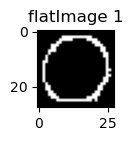

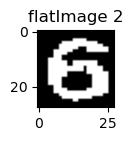

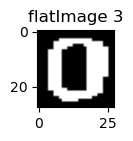

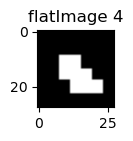

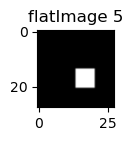

In [18]:
w = 28
h = 28
isz = int(w*h*1.5)
noff = 0
ncnt = 0
while(noff<len(dat)):
    idat = dat[noff:noff+isz]
    ncnt += 1
    noff+= isz
    idat = np.reshape(idat,(int(h*1.5),w),'C')
    rgb = plot_nv21_image(idat,w,h)
    plt.figure(figsize=(1,1))
    plt.imshow(rgb)
    plt.title('flatImage %d'%ncnt)

### Additional outputs

[-1.  1.  6.  7. 10. 13.] (50, 50)
[  0. 255.] (28, 28)
[  0. 255.] (28, 28)
[  0. 255.] (28, 28)
[  0. 255.] (28, 28)
[  0. 255.] (28, 28)


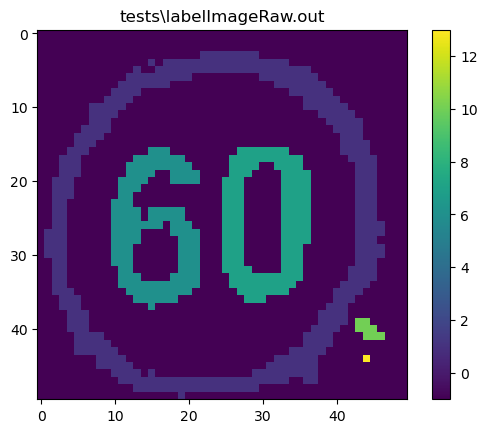

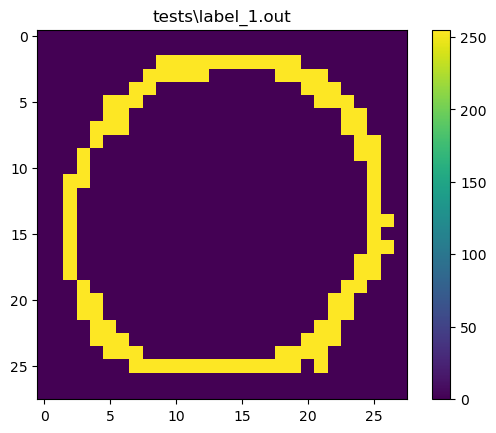

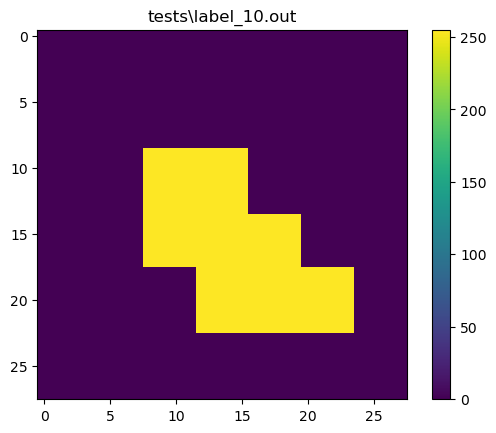

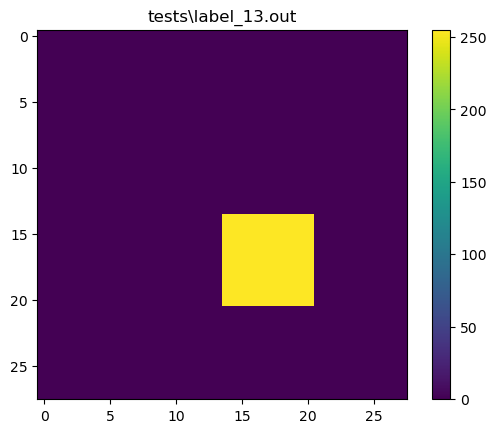

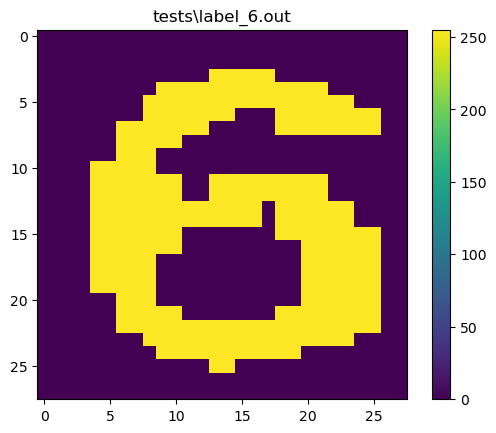

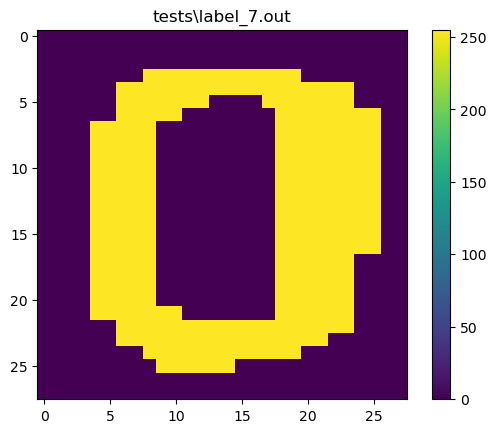

In [15]:
import glob
fils = glob.glob('tests/label*.out')
for dfil in fils:
    if (dfil.find('flat')>=0):
        continue
    readImageDat(dfil)
    plt.title(dfil)